#### 5.0 Model selection 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load your data
data_df = pd.read_pickle('/workspaces/maria272727fantasy_sports_assistant/data/parsed_data_all_positions.pkl')

# Step 1: Convert columns to numeric, coercing errors to NaN
for col in data_df.columns:
    if data_df[col].dtype == 'object':  # Only process object columns
        data_df[col] = pd.to_numeric(data_df[col], errors='coerce')

# Step 2: Handle missing values
data_df.fillna(data_df.mean(), inplace=True)

# Step 3: Select numeric columns for model training
numeric_columns = [
    'Age', 'Exp', 'G', 'Cmp', 'Att', 'Cm%', 'PYd', 'Y/Att', 'PTD', 'Int', 
    'Rsh', 'RshYd', 'RshTD', 'FP/G', 'FantPt', 'Y/Rsh', 'Rec', 'RecYd', 
    'RecTD', 'Y/Rec', 'Year', 'Week'
]
df_model_clean = data_df[numeric_columns]

# Step 4: Separate features (X) and target (y)
X = df_model_clean.drop(columns=['FantPt'])  # Features (everything except 'FantPt')
y = df_model_clean['FantPt']  # Target variable

# Step 5: Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 7: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 8: Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Mean Absolute Error (MAE): 0.00
Mean Squared Error (MSE): 0.00
R-squared (R²): 1.00


#### 5.1 Train-test-split

In [2]:
# Assuming you have X (features) and y (target) ready after preprocessing
X = data_df[numeric_columns]  # Select numeric columns or your chosen feature columns
y = data_df['FantPt']  # Assuming you are predicting 'FantPt' (Fantasy Points)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

####5.1 Hyperparameter Tuning with RandomizedSearchCV

In [3]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['auto', 'sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    model, param_distributions=param_dist, n_iter=50, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42
)
random_search.fit(X_train, y_train)

/home/vscode/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
105 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
105 fits failed with the following error:
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vscode/.local/lib/python3.10/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/vscode/.local/lib/python3.10/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/home/vscode/.lo

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7757aaf7e4d0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x77577fcd93c0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7757aafcfac0>},
                   random_state=42, scoring='neg_mean_absolute_error')

In [4]:
# Get the best hyperparameters from the search
best_params = random_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Get the best score (negative MAE) from the search
best_score = random_search.best_score_
print(f"Best score (negative MAE): {best_score}")

Best hyperparameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 287}
Best score (negative MAE): -0.057777811179949665


In [5]:
# Get the best model (with optimal hyperparameters)
best_model = random_search.best_estimator_

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics (MAE, MSE, R²)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Set MAE: {mae:.2f}")
print(f"Test Set MSE: {mse:.2f}")
print(f"Test Set R²: {r2:.2f}")

Test Set MAE: 0.05
Test Set MSE: 0.03
Test Set R²: 1.00


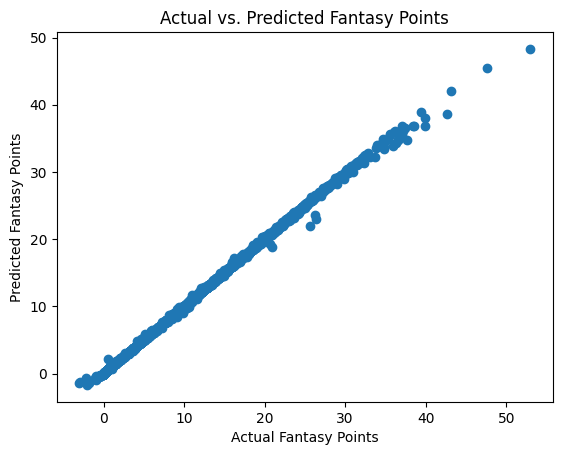

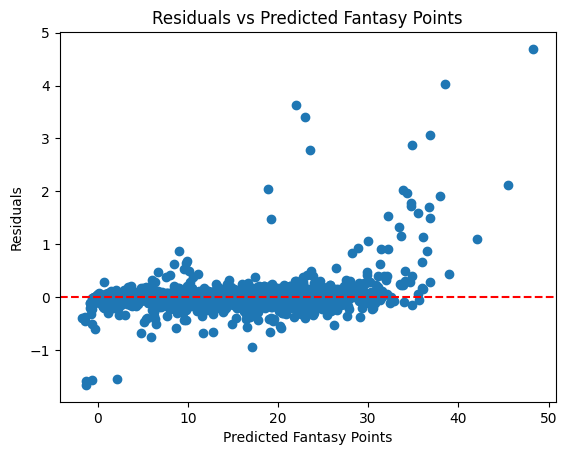

In [6]:
import matplotlib.pyplot as plt

# Plot predicted vs actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Fantasy Points')
plt.ylabel('Predicted Fantasy Points')
plt.title('Actual vs. Predicted Fantasy Points')
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Fantasy Points')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Fantasy Points')
plt.show()

##### 5.3 Model Interpretation

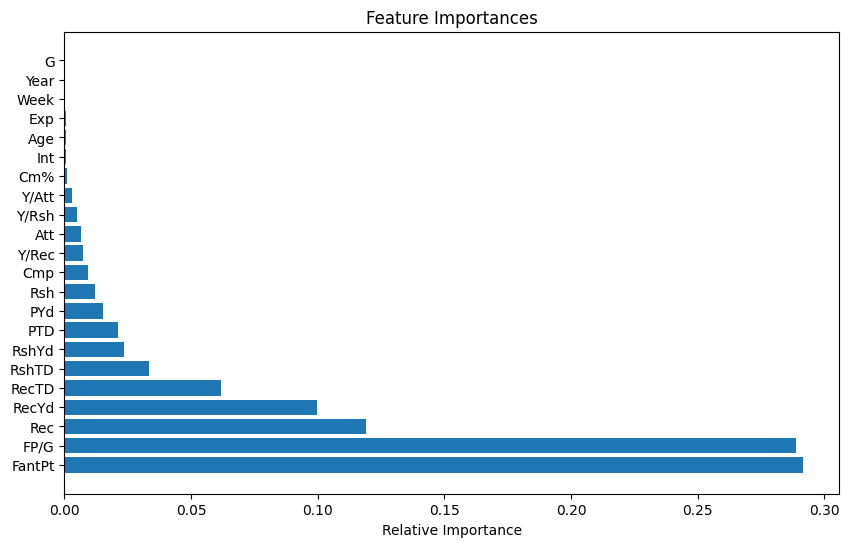

In [7]:
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(X_train.shape[1]), importances[indices], align="center")
plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
plt.xlabel("Relative Importance")
plt.show()

In [8]:
import xgboost as xgb
# Initialize and train the XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_y_pred = xgb_model.predict(X_test)

# Evaluate XGBoost
xgb_mae = mean_absolute_error(y_test, xgb_y_pred)
xgb_r2 = r2_score(y_test, xgb_y_pred)

print(f"XGBoost - MAE: {xgb_mae:.2f}, R²: {xgb_r2:.2f}")

XGBoost - MAE: 0.04, R²: 1.00


#### 5.2 Random forest model with grid search 

In [9]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Define the model (XGBoost Regressor)
xg_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Fit the model
xg_model.fit(X_train, y_train)

# Make predictions
y_pred_xg = xg_model.predict(X_test)

# Evaluate performance
mse_xg = mean_squared_error(y_test, y_pred_xg)
r2_xg = r2_score(y_test, y_pred_xg)

print(f"XGBoost - Mean Squared Error: {mse_xg}")
print(f"XGBoost - R-squared: {r2_xg}")

XGBoost - Mean Squared Error: 0.02837657378257849
XGBoost - R-squared: 0.9995340856746301


##### 5.3 Hyperparameter tunning 

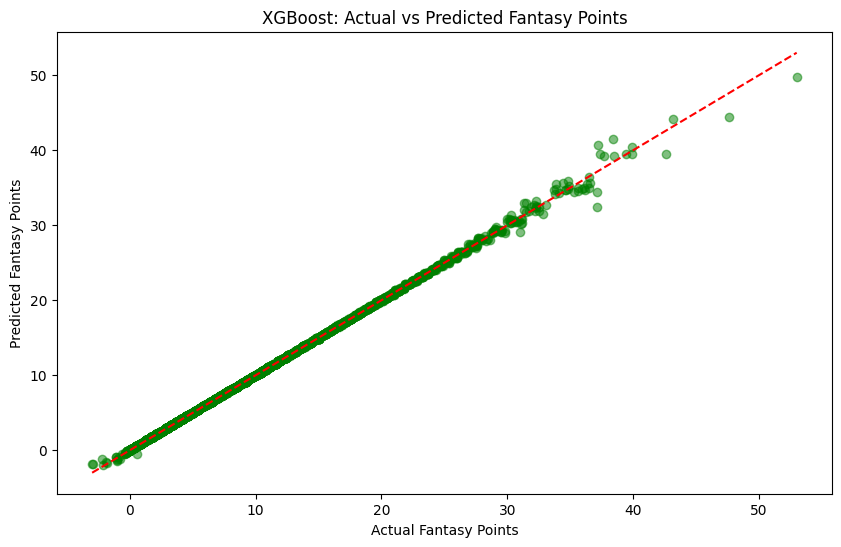

In [10]:
# Make predictions using the XGBoost model
y_pred_xg = xg_model.predict(X_test)

# Plotting Actual vs Predicted Fantasy Points for XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xg, color='green', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Fantasy Points')
plt.ylabel('Predicted Fantasy Points')
plt.title('XGBoost: Actual vs Predicted Fantasy Points')
plt.show()

In [11]:
import joblib
from sklearn.ensemble import RandomForestRegressor

# Assuming X_train and y_train are already defined
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Save the trained model to a .pkl file
joblib.dump(rf_model, 'best_rf_model.pkl')

['best_rf_model.pkl']

In [12]:
import joblib

# Load the trained model
rf_model = joblib.load('best_rf_model.pkl')

In [13]:
import streamlit as st
import joblib

# Load the trained model
model = joblib.load('best_rf_model.pkl')

# Streamlit user interface
st.title('Fantasy Points Prediction')

# User inputs
player_stats = st.text_input("Enter player stats: ")

# Make prediction when button is clicked
if st.button('Predict Fantasy Points'):
    input_data = [float(x) for x in player_stats.split(',')]
    prediction = model.predict([input_data])
    st.write(f"Predicted Fantasy Points: {prediction[0]}")

2025-01-28 22:40:10.075 
  command:

    streamlit run /usr/local/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
